# Analyze Portfolio via a standard process

- Gather stocks of interest
- Gather stocks from specific criteria (SP500 top 50...)
- Gather stocks from specific portfolio account
- Assemble stock universe 
- Gather price histories
- Compute aplha factors (X)
    - Compute custom apha factors
    - Compute univeral quant factors
    - Compute date information
- Compute target values (y)
    - Quantize with 2 bins for testing
    - Quantize with 25 bins for production
- Generate Optimal Portfolio
- Report on new portfolio

In [1]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

import importlib
import trading_functions as tf
importlib.reload(tf)
from trading_functions import Returns
from trading_functions import Data

import utils
importlib.reload(utils)

portfun = tf.Portfolio()
selfun = tf.Selection()

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
importlib.reload(portfolio_optimizer)

import ameritrade_functions as amc
importlib.reload(amc)

print(f'Python version: {python_version()}')
print(f'Pandas version: {pd.__version__}')

Python version: 3.8.10
Pandas version: 0.25.3


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [2]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

masked_account_number = '#---5311'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories.csv'

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but that has not been coded yet.)

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

In [3]:
td_ameritrade = amc.AmeritradeRest(username, password, client_id)
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

You have authorization


## Stock Universe

Here we setup the univers. This needs some work. The long term goal is to use a pipeline process to help select stock that are in the top 500 or something similare.

For now we will use stocks from the portfolio, but stocks of interest (high news items), a list of well known stocks (this also has been augmented with some stocks that made Ameritrade's top 10 movers for a couple of days. This Ameritrade funciton has not been coded yet, but should be add down the line to automate pulling these tickers.

In [4]:
from trading_functions import Data

symbols_of_interest = ['MGM', 'PDYPF', 'NNXPF', 'WKHS']
# Hardcoded for now
symbols_via_specific_criteria = ['AAPL',
                                 'MSFT',
                                 'GOOG',
                                 'TSLA',
                                 'COKE',
                                 'IBM',
                                 'BABA',
                                 'GMGMF',
                                 'OEG',
                                 'LX',
                                 'AIH',
                                 'NMRD',
                                 'CAN',
                                 'MOSY',
                                 'QFIN',
                                 'OCG',
                                 'PRTK',
                                 'ZKIN', 
                                 'EFOI',
                                 'CONN',
                                 'LEDS',
                                 'TELL',
                                 'JZXN',
                                 'VTNR',
                                 'AEI',
                                 'IPQ',
                                 'RCON'
                                ]

# Specific Portfolio Account
account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')

stock_universe = set(symbols_of_interest + symbols_via_specific_criteria + utils.get_investment_symbols(equity_investments_df))
holdings = utils.get_holdings(equity_investments_df, stock_universe)['marketValue']
display(holdings)

symbol
DKNG      2580.00
EEENF        7.04
FGPHF     9900.00
FNCL      3538.94
SCHA      2201.85
SCHF      9131.43
SCHM      6458.32
TLRY     13913.91
VBK       2036.65
VBR       2279.29
VGK       9472.40
VTI      38752.00
VXF       6635.65
WKHS     15450.00
LX           0.00
CONN         0.00
GOOG         0.00
BABA         0.00
OCG          0.00
AAPL         0.00
ZKIN         0.00
EFOI         0.00
MGM          0.00
TELL         0.00
RCON         0.00
COKE         0.00
AIH          0.00
CAN          0.00
MOSY         0.00
NMRD         0.00
IBM          0.00
OEG          0.00
LEDS         0.00
IPQ          0.00
TSLA         0.00
PDYPF        0.00
GMGMF        0.00
VTNR         0.00
NNXPF        0.00
JZXN         0.00
QFIN         0.00
PRTK         0.00
AEI          0.00
MSFT         0.00
Name: marketValue, dtype: float64

## Portfolio weights

With the portfolio stocks and the additional stocks, show how each of them contribute to the portfolio. Later, once we produce an optimized portfolio, we can generate a report on how much stock to buy/sell based of what we already have.

In [5]:
holding_weights = utils.get_portfolio_weights(holdings)
display(holding_weights)

symbol
AAPL     0.000000
AEI      0.000000
AIH      0.000000
BABA     0.000000
CAN      0.000000
COKE     0.000000
CONN     0.000000
DKNG     0.021086
EEENF    0.000058
EFOI     0.000000
FGPHF    0.080910
FNCL     0.028923
GMGMF    0.000000
GOOG     0.000000
IBM      0.000000
IPQ      0.000000
JZXN     0.000000
LEDS     0.000000
LX       0.000000
MGM      0.000000
MOSY     0.000000
MSFT     0.000000
NMRD     0.000000
NNXPF    0.000000
OCG      0.000000
OEG      0.000000
PDYPF    0.000000
PRTK     0.000000
QFIN     0.000000
RCON     0.000000
SCHA     0.017995
SCHF     0.074629
SCHM     0.052782
TELL     0.000000
TLRY     0.113715
TSLA     0.000000
VBK      0.016645
VBR      0.018628
VGK      0.077416
VTI      0.316711
VTNR     0.000000
VXF      0.054232
WKHS     0.126269
ZKIN     0.000000
dtype: float64

# Price History data

One you have a set of investments you want to work with, you will need to pull some historical data for them.

In [6]:
number_of_years = 5
#price_histories = td_ameritrade.get_price_histories(stock_universe, datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
#utils.save_price_histories(price_histories, price_histories_file_name)

In [7]:
price_histories.head()

NameError: name 'price_histories' is not defined

In [16]:
price_histories = utils.read_price_histories(price_histories_file_name)
pricing = Data().get_close_values(price_histories)

## Factors

In [5]:
import trading_factors as alpha_factors
importlib.reload(alpha_factors)
import alphalens as al

In [10]:
all_factors = pd.concat(
[
    alpha_factors.FactorMomentum(price_histories, 252).demean().rank().zscore().for_al(),
    alpha_factors.FactorMeanReversion(price_histories, 5).demean().rank().zscore().smoothed().rank().zscore().for_al(),
    alpha_factors.OvernightSentiment(price_histories, 5).demean().rank().zscore().smoothed(10).rank().zscore().for_al()
], axis=1)
all_factors.sort_index(inplace=True)

## Universal Quant Features

- Volatility 
- Dollar Volume
- Market Dispersion
- Market Volatility

#TODO: SMA for market disp/vol

In [11]:
all_factors = pd.concat(
[
    all_factors,
    alpha_factors.AnnualizedVolatility(price_histories, 20).rank().zscore().for_al(),
    alpha_factors.AnnualizedVolatility(price_histories, 120).rank().zscore().for_al(),
    alpha_factors.AverageDollarVolume(price_histories, 20).rank().zscore().for_al(),
    alpha_factors.AverageDollarVolume(price_histories, 120).rank().zscore().for_al(),
    alpha_factors.MarketDispersion(price_histories, 20).for_al(),
    alpha_factors.MarketDispersion(price_histories, 120).for_al(),
    alpha_factors.MarketVolatility(price_histories, 20).for_al(),
    alpha_factors.MarketVolatility(price_histories, 120).for_al()
], axis=1)
all_factors.sort_index(inplace=True)

In [12]:
alpha_factors.FactorDateParts(all_factors)
all_factors.head()

momentum_252_day_logret  \
date                      ticker                            
2016-07-15 00:00:00+00:00 AAPL                        NaN   
                          AEI                         NaN   
                          AIH                         NaN   
                          BABA                        NaN   
                          CAN                         NaN   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2016-07-15 00:00:00+00:00 AAPL                                     NaN   
                          AEI                                      NaN   
                          AIH                                      NaN   
                          BABA                                     NaN   
                          CAN                                      NaN   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2016-07-15 00:00:00+00:00 AAPL                             -0.403216   
                          AEI                              -1.370935   
                          AIH                              -1.532221   
                          BABA                             -0.806432   
                          CAN                              -1.612864   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2016-07-15 00:00:00+00:00 AAPL                            NaN   
                          AEI                             NaN   
                          AIH                             NaN   
                          BABA                            NaN   
                          CAN                             NaN   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2016-07-15 00:00:00+00:00 AAPL                             NaN   
                          AEI                              NaN   
                          AIH                              NaN   
                          BABA                             NaN   
                          CAN                              NaN   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2016-07-15 00:00:00+00:00 AAPL                             NaN   
                          AEI                              NaN   
                          AIH                              NaN   
                          BABA                             NaN   
                          CAN                              NaN   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2016-07-15 00:00:00+00:00 AAPL                              NaN   
                          AEI                               NaN   
                          AIH                               NaN   
                          BABA                              NaN   
                          CAN                               NaN   

                                  market_dispersion20_day  \
date                      ticker                            
2016-07-15 00:00:00+00:00 AAPL                        NaN   
                          AEI                         NaN   
                          AIH                         NaN   
                          BABA                        NaN   
                          CAN                         NaN   

                                  market_dispersion120_day  \
date                      ticker                             
2016-07-15 00:00:00+00:00 AAPL                         NaN   
                          AEI                          NaN   
                          AIH                         

## Compute the target values (y) and Shift back to create a 5 day forward prediciton

In [13]:
target_source = '5Day2Quant'

all_factors = pd.concat(
[
    all_factors,
    alpha_factors.FactorReturnQuantiles(price_histories, 2, 5).for_al(target_source),
], axis=1).dropna()
all_factors.sort_index(inplace=True)
display(all_factors.head())

all_factors['target'] = all_factors.groupby(level='ticker')[target_source].shift(-5)
all_factors[[target_source,'target']].reset_index().sort_values(['ticker', 'date']).head(10)

momentum_252_day_logret  \
date                      ticker                            
2017-07-03 00:00:00+00:00 AAPL                   1.152787   
                          AEI                   -0.741077   
                          AIH                   -0.741077   
                          BABA                   1.399813   
                          CAN                   -0.741077   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2017-07-03 00:00:00+00:00 AAPL                                1.564497   
                          AEI                                 0.164684   
                          AIH                                 0.164684   
                          BABA                               -1.564497   
                          CAN                                 0.164684   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2017-07-03 00:00:00+00:00 AAPL                              0.402972   
                          AEI                              -1.370106   
                          AIH                              -1.531295   
                          BABA                              1.208917   
                          CAN                              -1.611889   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2017-07-03 00:00:00+00:00 AAPL                       0.413671   
                          AEI                       -1.116912   
                          AIH                       -1.116912   
                          BABA                       0.579140   
                          CAN                       -1.116912   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2017-07-03 00:00:00+00:00 AAPL                        0.247026   
                          AEI                        -1.152787   
                          AIH                        -1.152787   
                          BABA                        0.905761   
                          CAN                        -1.152787   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2017-07-03 00:00:00+00:00 AAPL                        1.737419   
                          AEI                        -1.116912   
                          AIH                        -1.116912   
                          BABA                        1.654685   
                          CAN                        -1.116912   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2017-07-03 00:00:00+00:00 AAPL                         1.722068   
                          AEI                         -1.189047   
                          AIH                         -1.189047   
                          BABA                         1.476058   
                          CAN                         -1.189047   

                                  market_dispersion20_day  \
date                      ticker                            
2017-07-03 00:00:00+00:00 AAPL                    0.03368   
                          AEI                     0.03368   
                          AIH                     0.03368   
                          BABA                    0.03368   
                          CAN                     0.03368   

                                  market_dispersion120_day  \
date                      ticker                             
2017-07-03 00:00:00+00:00 AAPL                    0.029254   
                          AEI                     0.029254   
                          AIH                     0.02

,date,ticker,5Day2Quant,target
0,2017-07-03 00:00:00+00:00,AAPL,0,1.0
43,2017-07-05 00:00:00+00:00,AAPL,1,1.0
86,2017-07-06 00:00:00+00:00,AAPL,0,1.0
129,2017-07-07 00:00:00+00:00,AAPL,1,1.0
172,2017-07-10 00:00:00+00:00,AAPL,1,1.0
215,2017-07-11 00:00:00+00:00,AAPL,1,1.0
258,2017-07-12 00:00:00+00:00,AAPL,1,1.0
301,2017-07-13 00:00:00+00:00,AAPL,1,1.0
344,2017-07-14 00:00:00+00:00,AAPL,1,1.0
387,2017-07-17 00:00:00+00:00,AAPL,1,1.0


### IID Check of Target
Let's see if the returns are independent and identically distributed.

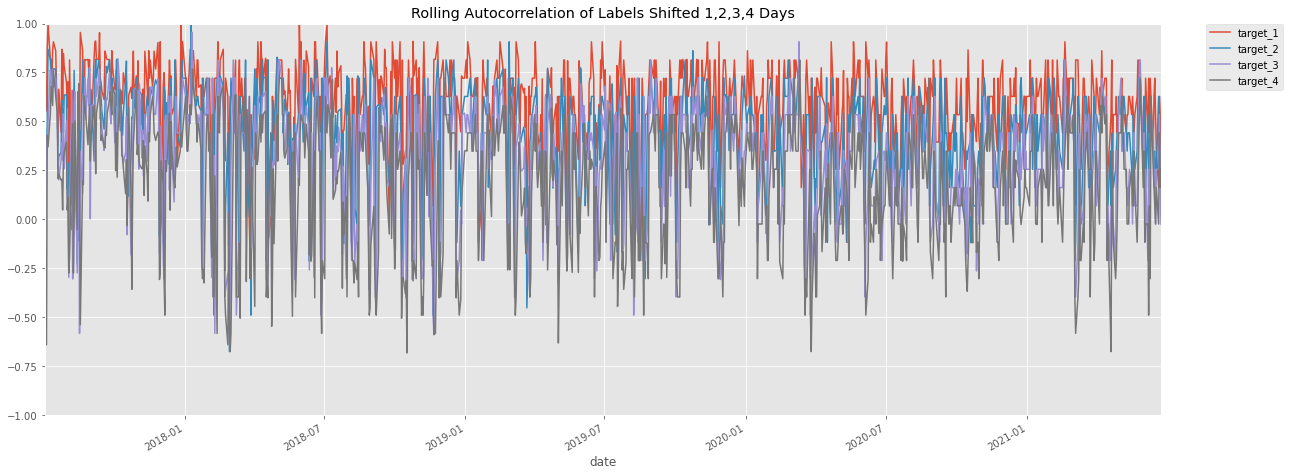

In [14]:
from scipy.stats import spearmanr

def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]


all_factors['target_1'] = all_factors.groupby(level='ticker')[target_source].shift(-4)
all_factors['target_2'] = all_factors.groupby(level='ticker')[target_source].shift(-3)
all_factors['target_3'] = all_factors.groupby(level='ticker')[target_source].shift(-2)
all_factors['target_4'] = all_factors.groupby(level='ticker')[target_source].shift(-1)

g = all_factors.dropna().groupby(level='date')
for i in range(4):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, 'target', label)
    ic.plot(ylim=(-1, 1), label=label)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

In [15]:
all_factors.to_csv('data/factor_features_data.csv')

In [3]:
all_factors = pd.read_csv('data/factor_features_data.csv', parse_dates=['date'])
all_factors.set_index(['date', 'ticker'], inplace=True)
all_factors.sort_index(inplace=True)
all_factors.head()

momentum_252_day_logret  \
date                      ticker                            
2017-07-03 00:00:00+00:00 AAPL                   1.152787   
                          AEI                   -0.741077   
                          AIH                   -0.741077   
                          BABA                   1.399813   
                          CAN                   -0.741077   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2017-07-03 00:00:00+00:00 AAPL                                1.564497   
                          AEI                                 0.164684   
                          AIH                                 0.164684   
                          BABA                               -1.564497   
                          CAN                                 0.164684   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2017-07-03 00:00:00+00:00 AAPL                              0.402972   
                          AEI                              -1.370106   
                          AIH                              -1.531295   
                          BABA                              1.208917   
                          CAN                              -1.611889   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2017-07-03 00:00:00+00:00 AAPL                       0.413671   
                          AEI                       -1.116912   
                          AIH                       -1.116912   
                          BABA                       0.579140   
                          CAN                       -1.116912   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2017-07-03 00:00:00+00:00 AAPL                        0.247026   
                          AEI                        -1.152787   
                          AIH                        -1.152787   
                          BABA                        0.905761   
                          CAN                        -1.152787   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2017-07-03 00:00:00+00:00 AAPL                        1.737419   
                          AEI                        -1.116912   
                          AIH                        -1.116912   
                          BABA                        1.654685   
                          CAN                        -1.116912   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2017-07-03 00:00:00+00:00 AAPL                         1.722068   
                          AEI                         -1.189047   
                          AIH                         -1.189047   
                          BABA                         1.476058   
                          CAN                         -1.189047   

                                  market_dispersion20_day  \
date                      ticker                            
2017-07-03 00:00:00+00:00 AAPL                    0.03368   
                          AEI                     0.03368   
                          AIH                     0.03368   
                          BABA                    0.03368   
                          CAN                     0.03368   

                                  market_dispersion120_day  \
date                      ticker                             
2017-07-03 00:00:00+00:00 AAPL                    0.029254   
                          AEI                     0.029254   
                          AIH                     0.02

In [4]:
all_factors.columns.values

array(['momentum_252_day_logret', 'mean_reversion_5_day_logret_smoothed',
       'overnight_sentiment_5_day_smoothed',
       'annualzed_volatility_20_day', 'annualzed_volatility_120_day',
       'average_dollar_volume_20_day', 'average_dollar_volume_120_day',
       'market_dispersion20_day', 'market_dispersion120_day',
       'market_volatility20_day', 'market_volatility120_day',
       'is_January', 'is_December', 'weekday', 'quarter', 'year',
       'month_start', 'month_end', 'quarter_start', 'quarter_end',
       '5Day2Quant', 'target', 'target_1', 'target_2', 'target_3',
       'target_4'], dtype=object)

In [5]:
import utils
importlib.reload(utils)

features = ['momentum_252_day_logret', 'mean_reversion_5_day_logret_smoothed',
       'overnight_sentiment_5_day_smoothed',
       'annualzed_volatility_20_day', 'annualzed_volatility_120_day',
       'average_dollar_volume_20_day', 'average_dollar_volume_120_day',
       'market_dispersion20_day', 'market_dispersion120_day',
       'market_volatility20_day', 'market_volatility120_day',
       'is_January', 'is_December', 'weekday', 'quarter', 'year',
       'month_start', 'month_end', 'quarter_start', 'quarter_end']

target_label = 'target'

temp = all_factors.dropna().copy()
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = utils.train_valid_test_split(X, y, 0.6, 0.2, 0.2)

X_train.head()

momentum_252_day_logret  \
date                      ticker                            
2017-07-03 00:00:00+00:00 AAPL                   1.152787   
                          AEI                   -0.741077   
                          AIH                   -0.741077   
                          BABA                   1.399813   
                          CAN                   -0.741077   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2017-07-03 00:00:00+00:00 AAPL                                1.564497   
                          AEI                                 0.164684   
                          AIH                                 0.164684   
                          BABA                               -1.564497   
                          CAN                                 0.164684   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2017-07-03 00:00:00+00:00 AAPL                              0.402972   
                          AEI                              -1.370106   
                          AIH                              -1.531295   
                          BABA                              1.208917   
                          CAN                              -1.611889   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2017-07-03 00:00:00+00:00 AAPL                       0.413671   
                          AEI                       -1.116912   
                          AIH                       -1.116912   
                          BABA                       0.579140   
                          CAN                       -1.116912   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2017-07-03 00:00:00+00:00 AAPL                        0.247026   
                          AEI                        -1.152787   
                          AIH                        -1.152787   
                          BABA                        0.905761   
                          CAN                        -1.152787   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2017-07-03 00:00:00+00:00 AAPL                        1.737419   
                          AEI                        -1.116912   
                          AIH                        -1.116912   
                          BABA                        1.654685   
                          CAN                        -1.116912   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2017-07-03 00:00:00+00:00 AAPL                         1.722068   
                          AEI                         -1.189047   
                          AIH                         -1.189047   
                          BABA                         1.476058   
                          CAN                         -1.189047   

                                  market_dispersion20_day  \
date                      ticker                            
2017-07-03 00:00:00+00:00 AAPL                    0.03368   
                          AEI                     0.03368   
                          AIH                     0.03368   
                          BABA                    0.03368   
                          CAN                     0.03368   

                                  market_dispersion120_day  \
date                      ticker                             
2017-07-03 00:00:00+00:00 AAPL                    0.029254   
                          AEI                     0.029254   
                          AIH                     0.02

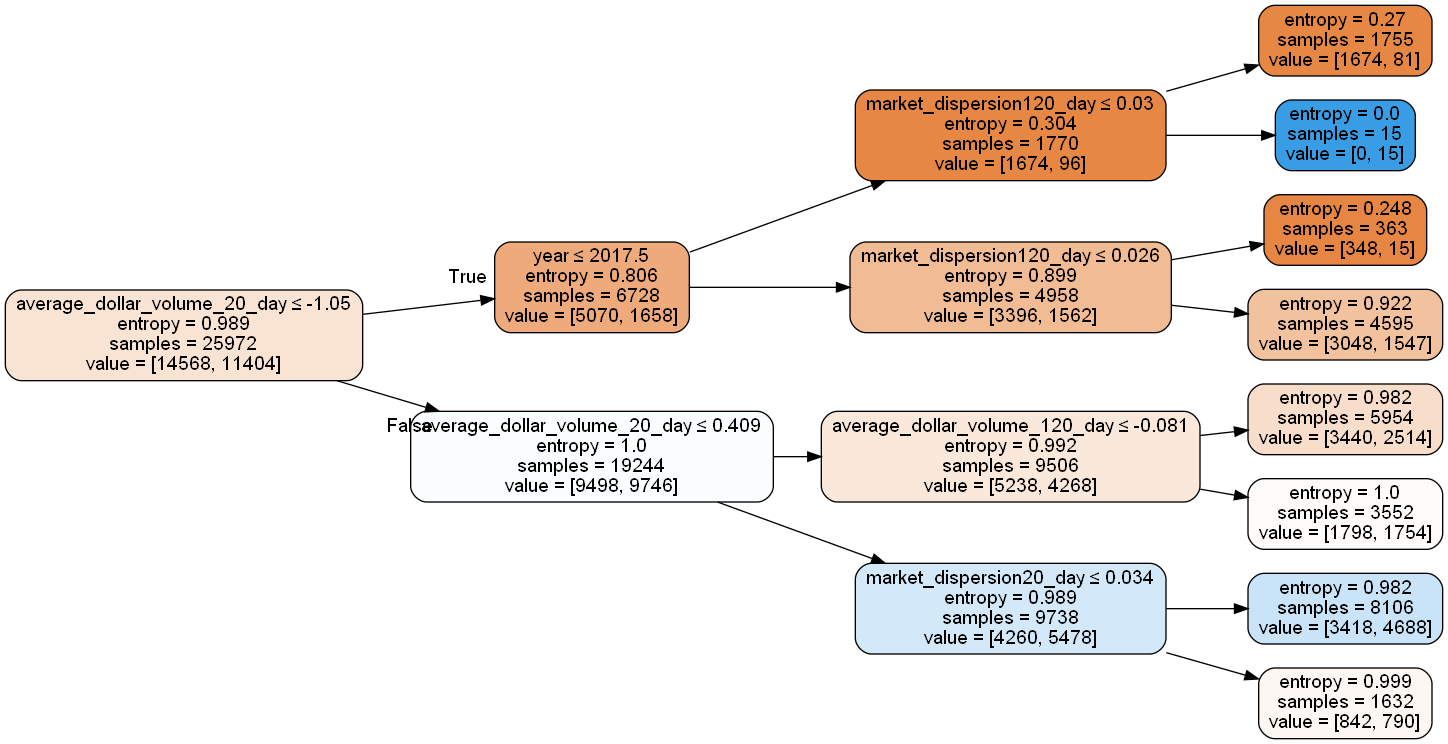

      Feature                                  Importance
 1. average_dollar_volume_20_day         (0.6371115074209405)
 2. year                                 (0.223471031058696)
 3. market_dispersion120_day             (0.10347725944522848)
 4. market_dispersion20_day              (0.018485396360647003)
 5. average_dollar_volume_120_day        (0.017454805714488184)
 6. quarter_end                          (0.0)
 7. mean_reversion_5_day_logret_smoothed (0.0)
 8. overnight_sentiment_5_day_smoothed   (0.0)
 9. annualzed_volatility_20_day          (0.0)
10. annualzed_volatility_120_day         (0.0)
11. market_volatility20_day              (0.0)
12. quarter_start                        (0.0)
13. market_volatility120_day             (0.0)
14. is_January                           (0.0)
15. is_December                          (0.0)
16. weekday                              (0.0)
17. quarter                              (0.0)
18. month_start                          (0.0)
19. month_end    

['average_dollar_volume_20_day',
 'year',
 'market_dispersion120_day',
 'market_dispersion20_day',
 'average_dollar_volume_120_day',
 'quarter_end',
 'mean_reversion_5_day_logret_smoothed',
 'overnight_sentiment_5_day_smoothed',
 'annualzed_volatility_20_day',
 'annualzed_volatility_120_day',
 'market_volatility20_day',
 'quarter_start',
 'market_volatility120_day',
 'is_January',
 'is_December',
 'weekday',
 'quarter',
 'month_start',
 'month_end',
 'momentum_252_day_logret']

In [6]:
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier
import utils
importlib.reload(utils)


# This is to get consistent results between each run.
clf_random_state = 0

simple_clf = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=clf_random_state)
simple_clf.fit(X_train, y_train)

display(utils.plot_tree_classifier(simple_clf, feature_names=features))
utils.rank_features_by_importance(simple_clf.feature_importances_, features)

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [7]:
n_days = 10
n_stocks = len(set(all_factors.index.get_level_values(level='ticker').values))

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 250, 500, 1000]

In [8]:
from sklearn.ensemble import RandomForestClassifier

train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models:   0%|          | 0/5 [00:00<?, ?Model/s]

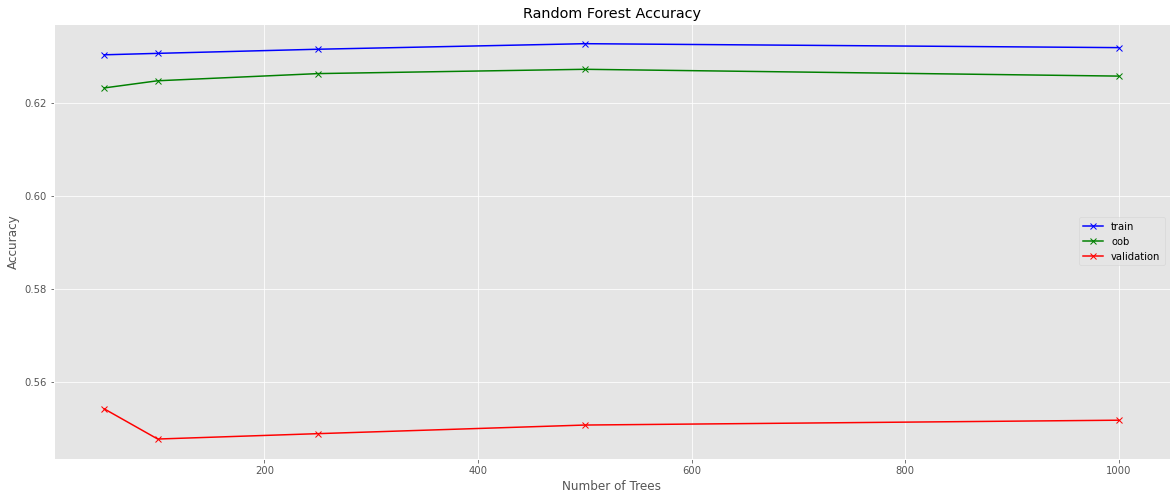

In [9]:
utils.plot_results(n_trees_l, train_score, oob_score, valid_score, ['train', 'oob', 'validation'], 'Random Forest Accuracy', 'Number of Trees')

In [10]:
print('Features Ranked by Average Importance:\n')
ranked_features = utils.rank_features_by_importance(np.average(feature_importances, axis=0), features)

Features Ranked by Average Importance:

      Feature                                  Importance
 1. average_dollar_volume_20_day         (0.18586580927410315)
 2. average_dollar_volume_120_day        (0.15721060482173094)
 3. annualzed_volatility_20_day          (0.15374989519693155)
 4. annualzed_volatility_120_day         (0.15056766567967833)
 5. momentum_252_day_logret              (0.059404686825443684)
 6. market_dispersion20_day              (0.04826168884772796)
 7. overnight_sentiment_5_day_smoothed   (0.04773490048426672)
 8. year                                 (0.047095771458878576)
 9. market_dispersion120_day             (0.04666714702462135)
10. market_volatility120_day             (0.041607103801553705)
11. market_volatility20_day              (0.025749380001571953)
12. mean_reversion_5_day_logret_smoothed (0.021114294362666517)
13. quarter                              (0.013467598508531159)
14. weekday                              (0.0011319069169096426)
15. is_Janua

In [11]:
ranked_features

['average_dollar_volume_20_day',
 'average_dollar_volume_120_day',
 'annualzed_volatility_20_day',
 'annualzed_volatility_120_day',
 'momentum_252_day_logret',
 'market_dispersion20_day',
 'overnight_sentiment_5_day_smoothed',
 'year',
 'market_dispersion120_day',
 'market_volatility120_day',
 'market_volatility20_day',
 'mean_reversion_5_day_logret_smoothed',
 'quarter',
 'weekday',
 'is_January',
 'is_December',
 'month_end',
 'month_start',
 'quarter_start',
 'quarter_end']

In [12]:
import abc

from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch


class NoOverlapVoterAbstract(VotingClassifier):
    @abc.abstractmethod
    def _calculate_oob_score(self, classifiers):
        raise NotImplementedError
        
    @abc.abstractmethod
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        raise NotImplementedError
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        self.estimator = estimator
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

#### Non Overlapping Estimators
With `calculate_oob_score` implemented, let's create non overlapping estimators. Implement `non_overlapping_estimators` to build non overlapping subsets of the data, then run a estimator on each subset of data.

In [13]:
class NoOverlapVoter(NoOverlapVoterAbstract):
    def _calculate_oob_score(self, classifiers):
        oob_scores = []
        for classifier in classifiers:
            oob_scores.append(classifier.oob_score_)

        return np.mean(oob_scores)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        fit_classifiers = []
        for clf_idx in range(len(classifiers)):
            x_samp, y_samp = utils.non_overlapping_samples(x, y, n_skip_samples, clf_idx)
            fit_classifiers.append(classifiers[clf_idx].fit(x_samp, y_samp))

        return fit_classifiers

Now that we have our `NoOverlapVoter` class, let's train it.

#### Train Model

Training Models:   0%|          | 0/5 [00:00<?, ?Model/s]

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass voting=soft as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass voting=soft as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass voting=soft as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\sklea

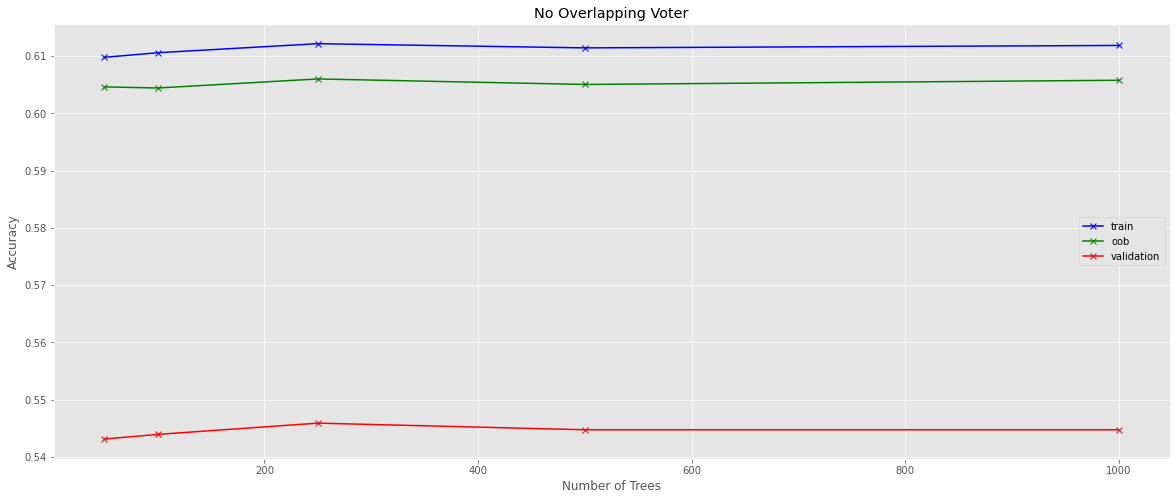

In [14]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)
    
utils.plot_results(n_trees_l, train_score, oob_score, valid_score, ['train', 'oob', 'validation'], 'No Overlapping Voter', 'Number of Trees')

In [17]:
import alphalens as al
importlib.reload(al)
import utils
importlib.reload(utils)
import trading_factors as alpha_factors
importlib.reload(alpha_factors)
print(al.__version__)

all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = price_histories

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'AI_ALPHA'
    factors_with_alpha = data.loc[samples.index].copy().reset_index()
    factors_with_alpha['date'] = pd.to_datetime(factors_with_alpha['date'])
    factors_with_alpha.set_index(['date', 'ticker'], inplace=True)
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = alpha_factors.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = alpha_factors.get_factor_returns(factor_data)
    sharpe_ratio = alpha_factors.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    alpha_factors.plot_factor_returns(factor_returns)
    alpha_factors.plot_factor_rank_autocorrelation(factor_data)

0.4.0


In [18]:
factor_names = [
     'mean_reversion_5_day_logret_smoothed',
     'momentum_252_day_logret',
     'overnight_sentiment_5_day_smoothed',
     'average_dollar_volume_120_day',
     'annualzed_volatility_20_day'
]


In [19]:
factor_names = [
     'mean_reversion_5_day_logret_smoothed',
     'momentum_252_day_logret',
     'overnight_sentiment_5_day_smoothed',
]

Cleaning Data...

Dropped 22.9% entries from factor data: 0.0% in forward returns computation and 22.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 33.0% entries from factor data: 0.0% in forward returns computation and 32.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                      Sharpe Ratio
mean_reversion_5_day_logret_smoothed          0.44
momentum_252_day_logret            

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


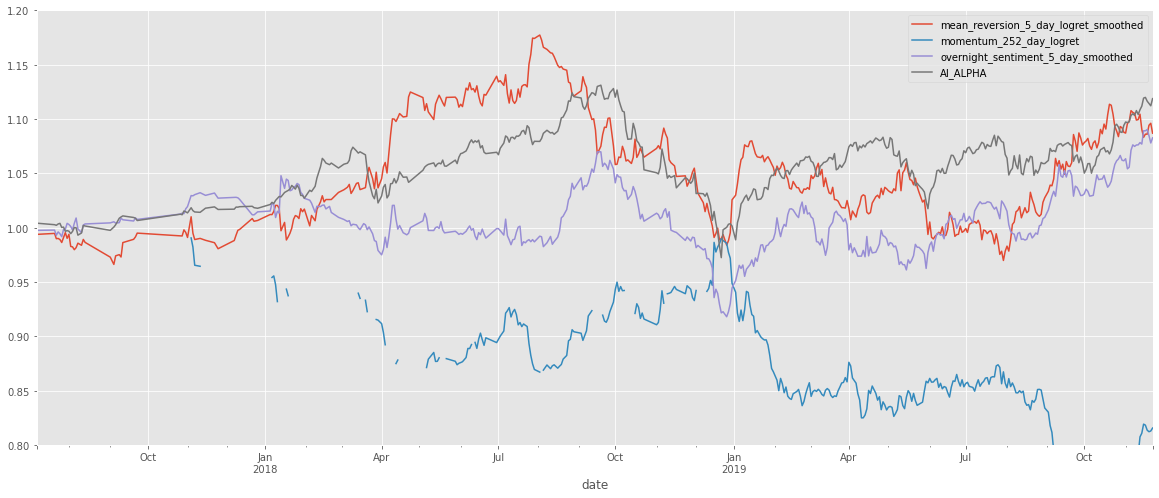

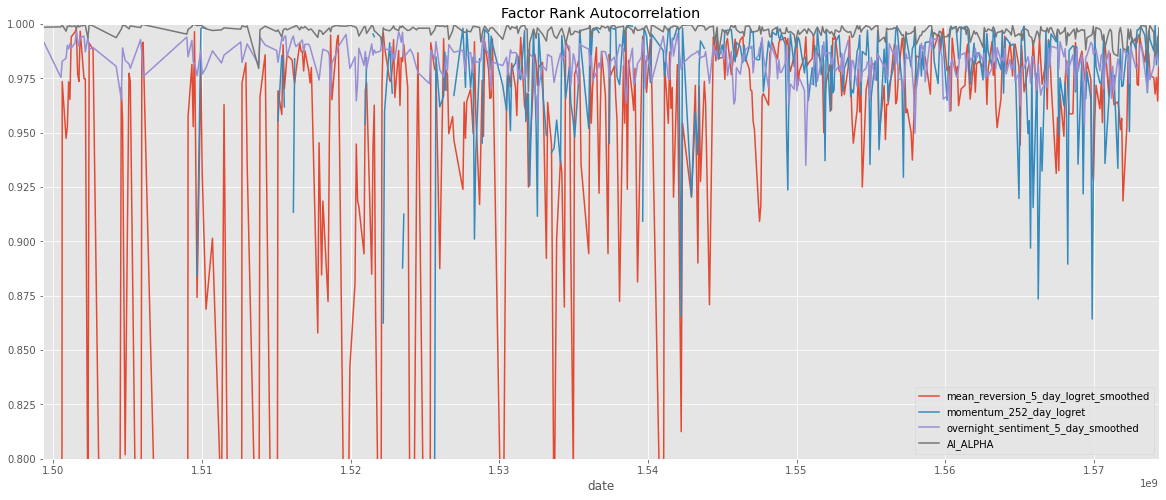

In [20]:
show_sample_results(all_factors.dropna(), X_train.dropna(), clf_nov, factor_names, pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                      Sharpe Ratio
mean_reversion_5_day_logret_smoothed         -0.48
momentum_252_day_logret                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


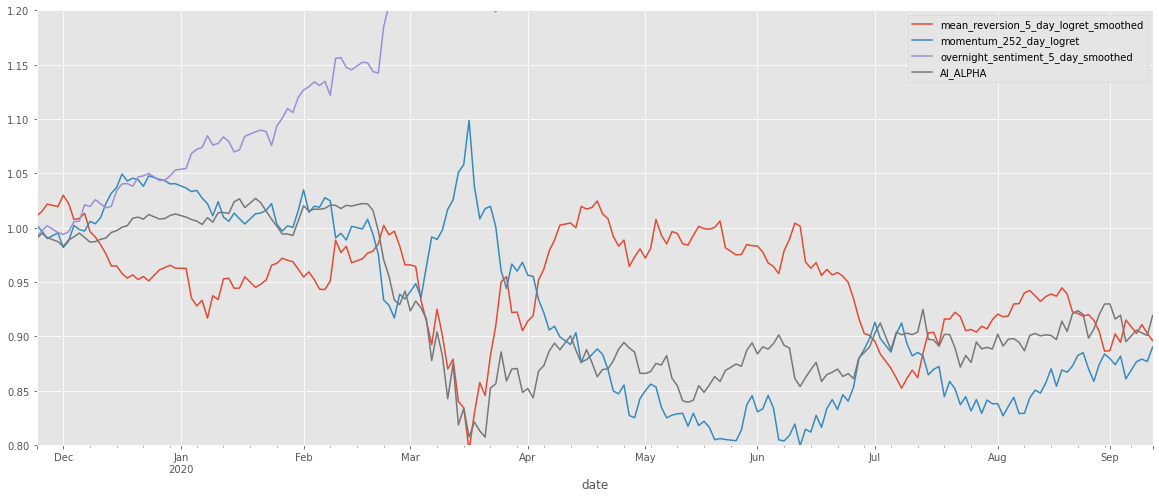

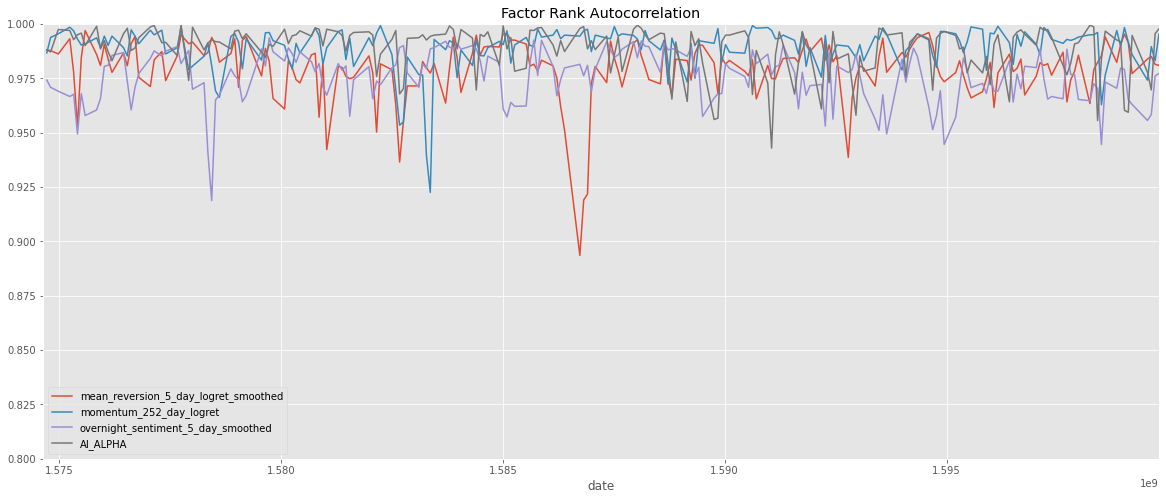

In [21]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names, pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [22]:
for n_trees in tqdm([500], desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(
        pd.concat([X_train, X_valid]),
        pd.concat([y_train, y_valid]))

Training Models:   0%|          | 0/1 [00:00<?, ?Model/s]

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass voting=soft as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [23]:
clf = RandomForestClassifier(500, **clf_parameters)

clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass voting=soft as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


NoOverlapVoter(estimator=RandomForestClassifier(criterion='entropy',
                                                min_samples_leaf=430,
                                                n_estimators=500, n_jobs=-1,
                                                oob_score=True,
                                                random_state=0))

### Results
#### Accuracy

In [24]:
print('train: {}, oob: {}, valid: {}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.oob_score_))

train: 0.6111966733405205, oob: 0.5677426819391415, valid: 0.595002166690741


#### Train

Cleaning Data...

Dropped 22.9% entries from factor data: 0.0% in forward returns computation and 22.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 33.0% entries from factor data: 0.0% in forward returns computation and 32.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                      Sharpe Ratio
mean_reversion_5_day_logret_smoothed          0.44
momentum_252_day_logret            

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


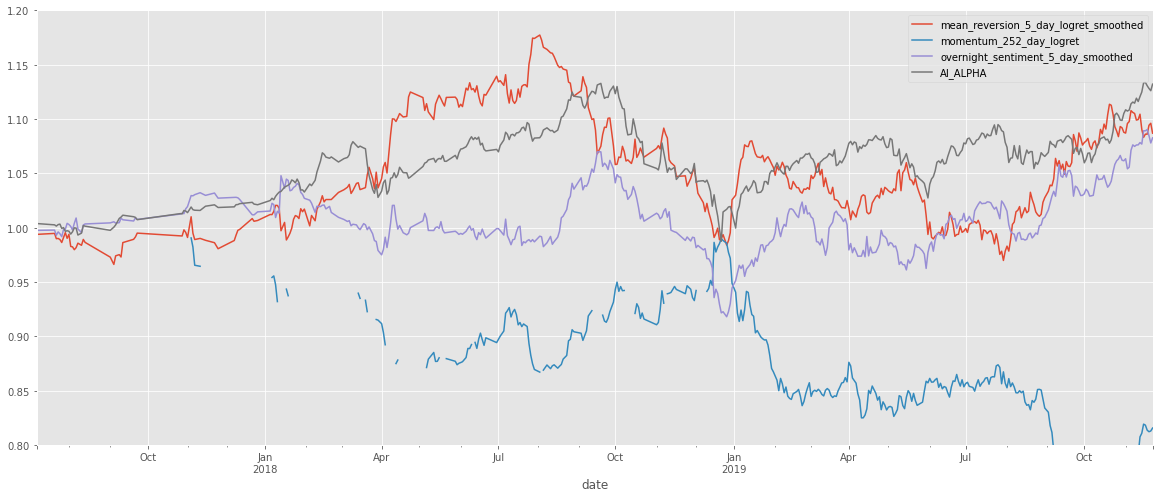

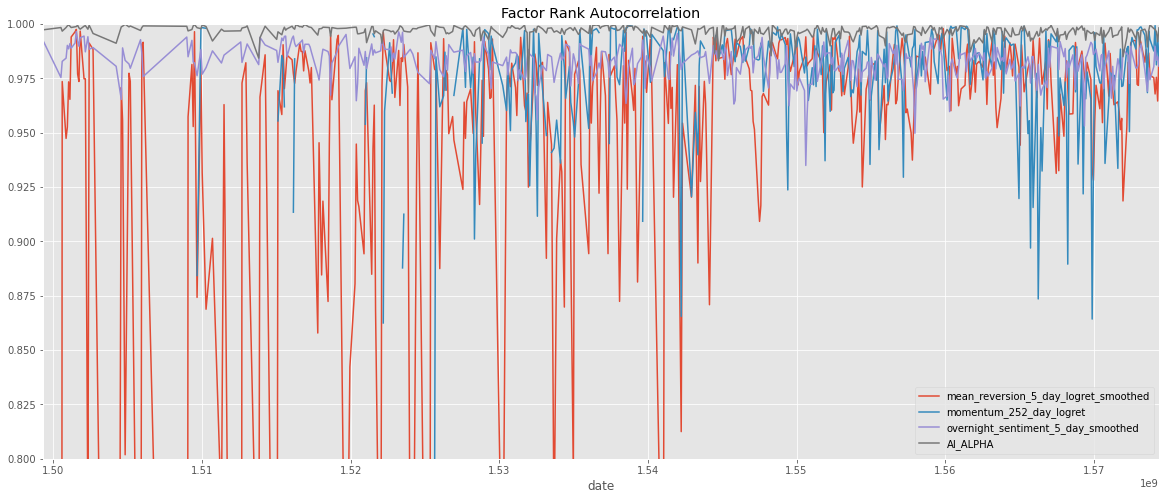

In [25]:
show_sample_results(all_factors, X_train, clf_nov, factor_names, pricing)

#### Validation

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                      Sharpe Ratio
mean_reversion_5_day_logret_smoothed         -0.48
momentum_252_day_logret                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


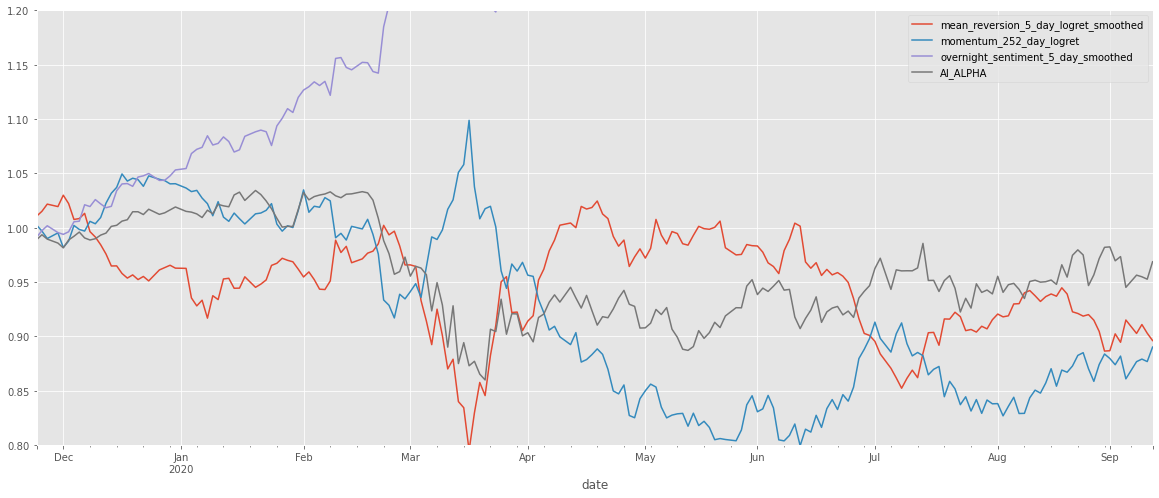

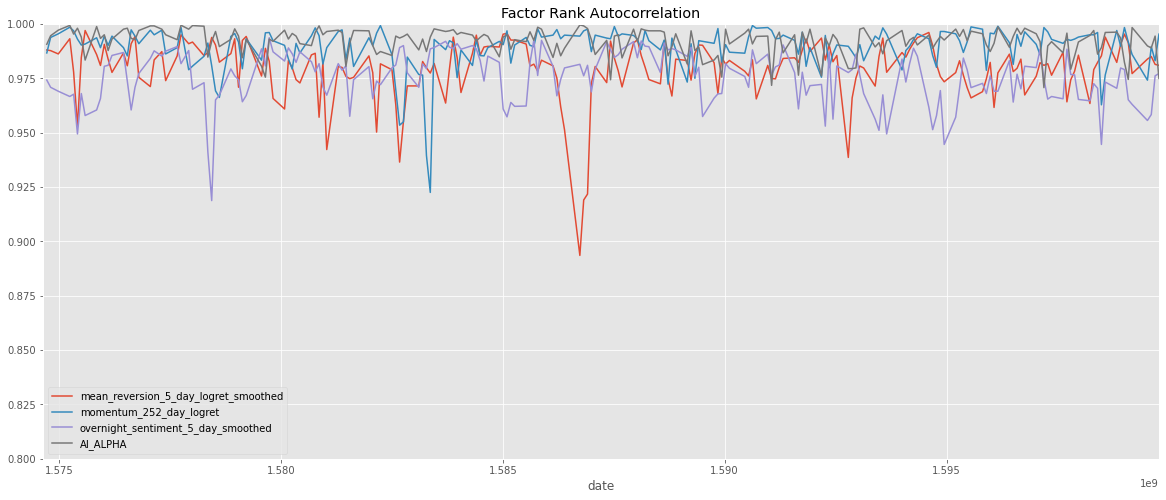

In [26]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names, pricing)

#### Test

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                      Sharpe Ratio
mean_reversion_5_day_logret_smoothed          1.31
momentum_252_day_logret                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


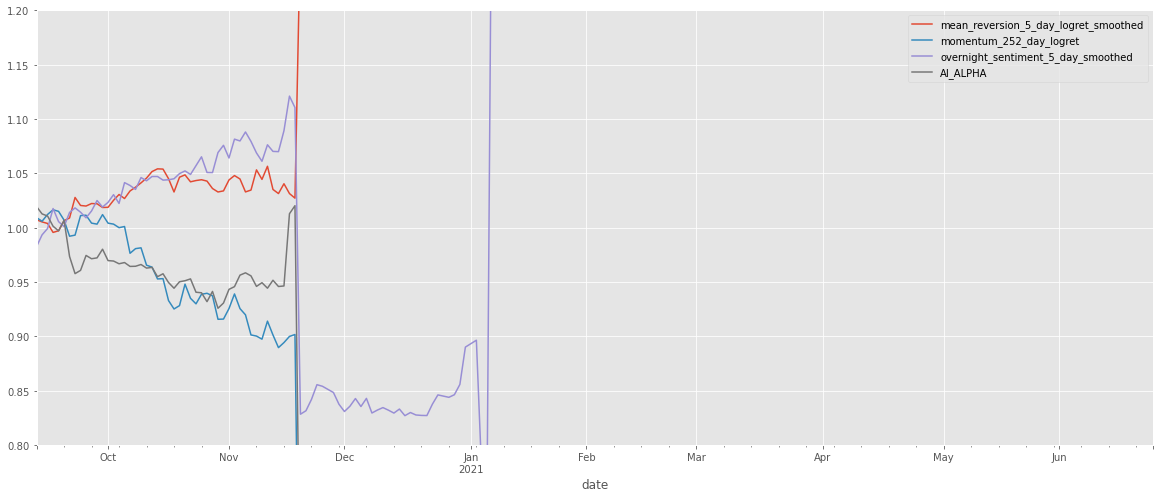

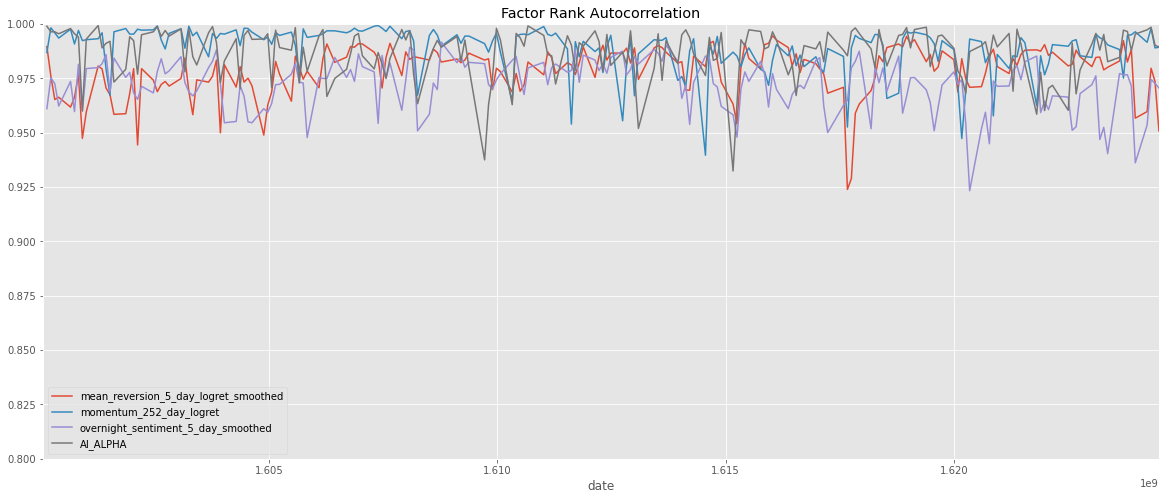

In [27]:
show_sample_results(all_factors, X_test, clf_nov, factor_names, pricing)

# Stopped here

# TODO

- Use AI Alpha from top factors
- Get daily Alpha/Beta/Idiosyncratic...
- Compute optimization parameters
- Init holdings
- Run Backtests
- Generate Portfolio

### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

In [28]:
optimal_weights = OptimalHoldings(risk_cap=0.05,weights_max=0.12, weights_min=-0.12).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
print(f'Old portfolio variance is:  {risk_model.compute_portfolio_variance(sotck_universe_weights):.8f}')
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')
display((optimal_weights*100).round(2))
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')

#x_axis = plt.axes().get_xaxis()
#x_axis.set_visible(False)

NameError: name 'alpha_vector' is not defined

In [ ]:
investment_amount = portfun.get_account_value(stock_universe_values).round(2)
print(f'Current investment amount: {investment_amount}')
optimal_weights['amount'] = (optimal_weights['optimalWeights'] * investment_amount).round(0)
optimal_weights['marketValue'] = stock_universe_values['marketValue']
optimal_weights['buy/sell'] = (optimal_weights['marketValue'] - optimal_weights['amount']) * -1
optimal_weights['close'] = pricing.iloc[-1]
optimal_weights['existingShares'] = stock_universe_values['longQuantity']
optimal_weights['deltaShares'] = (optimal_weights['buy/sell'] / optimal_weights['close']).round(0)
optimal_weights['deltaMarketValue'] = (optimal_weights['deltaShares'] * optimal_weights['close'])
optimal_weights['totalShares'] = (optimal_weights['existingShares'] + optimal_weights['deltaShares'])
optimal_weights['totalMarketValue'] = (optimal_weights['totalShares'] * optimal_weights['close'])
optimal_weights

## Think or Swim Simulator

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] <= 0) & (optimal_weights['deltaShares'] == 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)][['deltaMarketValue', 'totalMarketValue']].sum().round(2)